In [4]:
import pathlib
import gzip

import imageio
import nibabel
import tqdm
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

import fastai
from fastai.vision.all import *

## Options

In [5]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [6]:
seed = 42

device = torch.device('cuda')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import random

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=seed)

In [8]:
# Model parameters
output_size = 4

# Training parameters
epochs = 5
batch_size = 12
learning_rate = 1e-3

## Paths

In [9]:
# Data root
data_folder = pathlib.Path("./data")

# Input data
dataset_folder = data_folder / "dataset"
mask_folder = data_folder / "mask"

# Preprocessed data
unzipped_folder = data_folder / "unzipped"
renamed_folder = data_folder / "renamed"

# Transformed
images_folder = data_folder / "images"
masks_folder = data_folder / "masks"

# Saved models
models_folder = pathlib.Path("models")


## Dataset

Data dir structure

<pre>
├── dataset
│   ├── pat1.nii.gz
│   ├── pat2.nii.gz
|   |── ...
├── mask
│   ├── pat1_mask.nii
│   ├── pat2_mask.nii
|   |── ...

</pre>

In [7]:
# Create folders for preprocessed data
for folder in [unzipped_folder, renamed_folder, images_folder, masks_folder]:
    if not folder.exists():
        folder.mkdir()

In [ ]:
# Unzip NIfTI files
for file in tqdm.tqdm(dataset_folder.glob("*.gz")):
    with gzip.open(file, 'rb') as inf:
        with open(f'{unzipped_folder}/{file.stem}', "wb") as ouf:
            shutil.copyfileobj(inf, ouf)

11it [00:12,  1.18s/it]

In [ ]:
# Mask filenames must match image filenames
for file in tqdm.tqdm(mask_folder.glob("*.nii")):
    shutil.copyfile(file, renamed_folder / file.stem.replace("_mask", ".nii"))

In [ ]:
# Find matches between images and masks by filename
matches = []
for file in unzipped_folder.glob("*.nii"):
    if (renamed_folder / file.name).exists():
        matches.append(os.path.basename(file)) 

In [ ]:
# Convert NIfTI to png before processing
pbar = tqdm.tqdm(matches)
for match in pbar:
    for folder in [unzipped_folder, renamed_folder]:
        file = folder / match
        pbar.set_description("Processing %s" % match)

        img = nibabel.load(file)
        image_array = np.asanyarray(img.dataobj)
        width, height, slices = image_array.shape

        # Save each slice as separate file
        for current in range(0, slices):
            image_name = file.stem + "_z" + "{:0>3}".format(str(current+1))+ ".png"
            image_path = masks_folder
            data = image_array[:, :, current]

            # Rescale data for images (no need to do it for masks)
            if folder == unzipped_folder:
                data = ((data - data.min()) / (data.max() - data.min())) * 255.0
                image_path = images_folder

            # Save final result to corresponding folder
            imageio.imwrite("{}/{}".format(image_path, image_name), np.uint8(data))

## Model

In [10]:
unet = resnet18

## Metrics

In [11]:
def IoU(preds: Tensor, targs: Tensor, eps: float = 1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]

    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)

    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]

        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()

        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)

    true_1_hot = true_1_hot.type(preds.type())

    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)  # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()  # find mean of class IoU values
    return iou

In [12]:
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None

class DiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = {},{}
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            p, t = TensorBase(p), TensorBase(t)
            c_inter = (p*t).float().sum().item()
            c_union = (p+t).float().sum().item()
            if c in self.inter:
                self.inter[c] += c_inter
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.union[c] = c_union
    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(binary_dice_scores, 2.*self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

In [13]:
class Dice_background(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): 
        self.axis = axis
        self.c = 0
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred = torch.where(pred == self.c, 1, 0)
        targ = torch.where(targ == self.c, 1, 0)
        
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None
    

class Dice_GGO(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): 
        self.axis = axis
        self.c = 1
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred = torch.where(pred == self.c, 1, 0)
        targ = torch.where(targ == self.c, 1, 0)
        
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None
    

class Dice_Consolidation(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): 
        self.axis = axis
        self.c = 2
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred = torch.where(pred == self.c, 1, 0)
        targ = torch.where(targ == self.c, 1, 0)
        
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None
    
    
class Dice_Pleural_Effusion(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): 
        self.axis = axis
        self.c = 3
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred = torch.where(pred == self.c, 1, 0)
        targ = torch.where(targ == self.c, 1, 0)
        
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None

In [14]:
class JaccardCoeff(Dice):
    "Implementation of the Jaccard coefficient that is lighter in RAM"
    @property
    def value(self): return self.inter/(self.union-self.inter) if self.union > 0 else None

class JaccardCoeffMulti(DiceMulti):
    "Averaged Jaccard coefficient for multiclass target in segmentation"
    @property
    def value(self):
        binary_jaccard_scores = np.array([])
        for c in self.inter:
            binary_jaccard_scores = np.append(binary_jaccard_scores, self.inter[c]/(self.union[c] - self.inter[c]) if self.union[c] > 0 else np.nan)
        return np.nanmean(binary_jaccard_scores)

# DataLoaders

In [17]:
def get_my_y(fname:Path):
    mask_name = str(fname).replace('images', 'masks')
    mask = Image.open(mask_name)
    mask = np.array(mask)
    return mask

tfms = [IntToFloatTensor(div_mask=1)]
db = DataBlock(blocks=(ImageBlock(), MaskBlock(codes=np.loadtxt('codes.txt', dtype=str))),
               get_x=noop,
               get_y=get_my_y,
               batch_tfms=tfms,
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=0.3)

               )
ds = db.datasets(source=data_folder / 'images')
dls = db.dataloaders(data_folder/'images',bs = batch_size)

# Train

In [18]:
criterion = torch.nn.CrossEntropyLoss()

learn = unet_learner(dls,unet, 
                     metrics=[IoU,DiceMulti, JaccardCoeffMulti, Dice_background, Dice_GGO, Dice_Consolidation, Dice_Pleural_Effusion],
                     n_out=output_size,
                     cbs=[SaveModelCallback(monitor='dice_multi',comp=np.greater,fname="covid19-dice_multi_best")]
                    ).to_fp16()

learn.fit_one_cycle(epochs,slice(learning_rate))
learn.save(f'covid19_last')

epoch,train_loss,valid_loss,IoU,dice_multi,jaccard_coeff_multi,dice_background,dice_ggo,dice__consolidation,dice__pleural__effusion,time
0,0.017451,0.015499,0.309197,0.658773,0.549186,0.997394,0.627583,0.268079,0.742038,17:46
1,0.012613,0.012397,0.326097,0.755362,0.643379,0.997852,0.724146,0.479455,0.819994,17:53
2,0.010750,0.010158,0.342661,0.805903,0.698881,0.998228,0.734780,0.623575,0.867028,17:54
3,0.008954,0.008695,0.351710,0.836734,0.737516,0.998423,0.778499,0.682322,0.887691,17:52
4,0.007828,0.008542,0.354663,0.841231,0.743122,0.998462,0.780468,0.695890,0.890106,17:54


Better model found at epoch 0 with dice_multi value: 0.658773335866677.
Better model found at epoch 1 with dice_multi value: 0.7553616007715871.
Better model found at epoch 2 with dice_multi value: 0.805902903676775.
Better model found at epoch 3 with dice_multi value: 0.8367336094820232.
Better model found at epoch 4 with dice_multi value: 0.8412314619180136.


Path('models/covid19_last.pth')

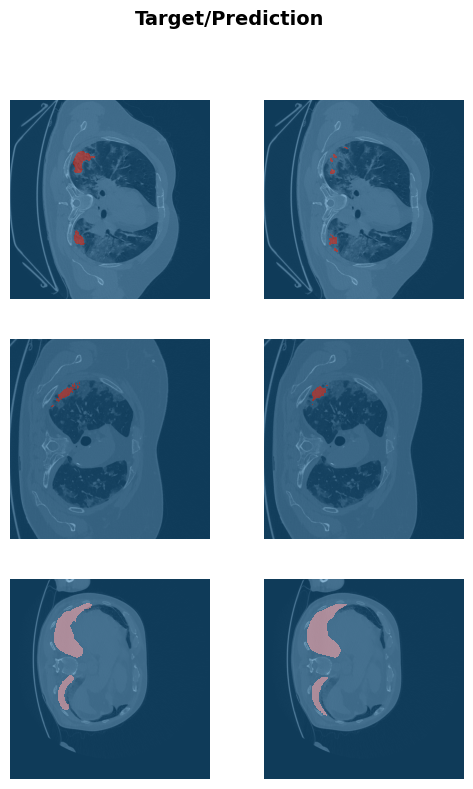

In [141]:
learn.show_results()

In [66]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower